In [1]:
from collections import OrderedDict
from contextlib import contextmanager
import random

# TODO(eric.cousineau): Use tensorboard in notebook.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader

In [2]:
import torch.nn.functional as F

In [3]:
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = 1000

In [4]:
def zero_grad(p):
    if p.grad is not None:
        p.grad.zero_()

In [5]:
def l1_loss(y, yh):
    return torch.mean(torch.abs(y - yh))

def mse_loss(y, yh):
    return torch.mean((y - yh)**2)

In [6]:
def flat_cat_detached(ps):
    return torch.cat([p.detach().view(-1) for p in ps])

In [7]:
class SequentialDict(nn.Sequential):
    """
    We must use OrderedDict because otherwise pytorch will sort the keys... I think?
    https://discuss.pytorch.org/t/append-for-nn-sequential-or-directly-converting-nn-modulelist-to-nn-sequential/7104/4
    https://github.com/pytorch/pytorch/pull/40905
    """
    def __init__(self, *args, **kwargs):
        super().__init__(OrderedDict(*args, **kwargs))

In [8]:
def seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)

In [9]:
class MLP(nn.Module):
    """Simple Multi-Layer Perceptron."""
    def __init__(
        self,
        num_inputs,
        num_outputs,
        *,
        num_hidden_units,
        num_layers,
        activation_cls,
    ):
        super().__init__()
        assert num_layers >= 2
        self.layers = SequentialDict()
        self.layers.input = SequentialDict(
            fcn=nn.Linear(num_inputs, num_hidden_units),
            activation=activation_cls(),
        )
        hidden = []
        for i in range(num_layers - 2):
            hidden.append(SequentialDict(
                fcn=nn.Linear(num_hidden_units, num_hidden_units),
                activation=activation_cls(),
            ))
        self.layers.hidden = nn.Sequential(*hidden)
        self.layers.output = SequentialDict(
            fcn=nn.Linear(num_hidden_units, num_outputs)
        )

    def forward(self, x):
        return self.layers(x)

In [10]:
# Derived from this kinda goal: https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030
class SaveActivations:
    def __init__(self):
        self.y = None

    def forward_hook(self, module, x, y):
        self.y = y.detach()

@contextmanager
def save_activations(module, cls):
    savers = []
    hooks = []
    for m in module.modules():
        if isinstance(m, cls):
            saver = SaveActivations()
            hook = m.register_forward_hook(saver.forward_hook)
            savers.append(saver)
            hooks.append(hook)
    assert len(hooks) > 0
    yield savers
    for hook in hooks:
        hook.remove()

def compute_activation_ratios(savers, clear=True):
    activation_ratios = []
    for saver in savers:
        assert saver.y is not None
        activated = (saver.y > 0)
        assert activated.ndim > 1
        N = activated.shape[0]
        assert N > 1 # BESPOKE DBG HACK!!
        # reduce along batch dimension using "or" (we want all act. at least somewhere in data)
        # dunno how to do batch sum along 
        activated_reduce = torch.sum(activated.to(torch.int), axis=0).to(torch.bool)
        activation_ratios.append(activated_reduce.to(torch.float).mean())
        if clear:
            saver.y = None
    return torch.tensor(activation_ratios)

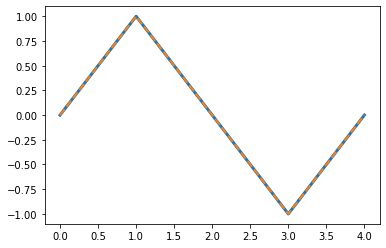

In [11]:
# I feel like an eediot.
@torch.no_grad()
def plot_pwa_via_relu():
    t = torch.linspace(0, 4, 5)
    y = F.relu(t) - 2 * F.relu(t - 1) + 2 * F.relu(t - 3)
    plt.plot(t.numpy(), y.numpy(), linewidth=3)
    
    fc1 = nn.Linear(1, 3)
    fc1.weight[:] = torch.tensor([1, 1, 1]).unsqueeze(-1)
    fc1.bias[:] = torch.tensor([0, -1, -3])
    act1 = nn.ReLU()
    fc2 = nn.Linear(3, 1, bias=False)
    fc2.weight[:] = torch.tensor([1, -2, 2])
    
    yh = t.unsqueeze(-1)
    yh = fc1(yh)
    yh = act1(yh)
    yh = fc2(yh)
    plt.plot(t.numpy(), yh.numpy(), linewidth=2, linestyle="--")

plot_pwa_via_relu()

In [12]:
# # Parameters.
# amplitude = 1.0
# period_sec = 1.0
# shift_sec = 0.0
# num_periods = 1.0
# dt = 0.1
# count_per_period = int(np.ceil(period_sec / dt))
# count = num_periods * count_per_period

with torch.no_grad():
    # t = torch.arange(count) * dt
    t = torch.linspace(0, 4.0, 9)

# def waveform(t):
#     omega = 2 * np.pi / period_sec
#     x = omega * (t + shift_sec)
#     return amplitude * torch.sin(x)

# def waveform(t):
#     c = 2.0
#     return c * t

def waveform(t):
    # Simple sawtooth wave.
    y = F.relu(t) - 2 * F.relu(t - 1) + 2 * F.relu(t - 3)
    return y

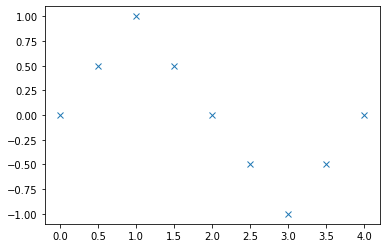

In [13]:
plt.plot(t.numpy(), waveform(t).detach().numpy(), 'x')

In [14]:
@torch.no_grad()
def gt_model():
    # Represent sawtooth w/ simple (but not unique) MLP.
    model = MLP(num_inputs=1, num_outputs=1, num_hidden_units=3, num_layers=3, activation_cls=nn.ReLU)
    model.layers.input.fcn.weight[:] = torch.tensor([1, 1, 1]).unsqueeze(-1)
    model.layers.input.fcn.bias[:] = torch.zeros(3)
    model.layers.hidden[0].fcn.weight[:] = torch.eye(3)
    model.layers.hidden[0].fcn.bias[:] = torch.tensor([0, -1, -3])
    model.layers.output.fcn.weight[:] = torch.tensor([[1, -2, 2]])
    model.layers.output.fcn.bias[:] = torch.zeros(1)
    return model

In [15]:
@torch.no_grad()
def perturb(model, noise):
    seed(0)
    for p in model.parameters():
        p += torch.normal(torch.zeros_like(p), noise)
    return model

In [16]:
@torch.no_grad()
def plot_model(model):
    y = model(t.unsqueeze(-1))
    plt.plot(t.numpy(), y.numpy())

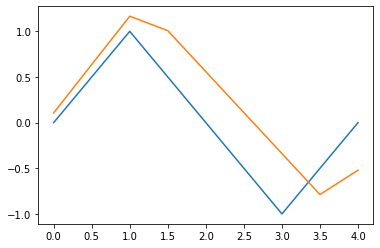

In [17]:
plot_model(gt_model())
plot_model(perturb(gt_model(), 0.05))

In [18]:
def rel_mean_abs(x, tol=torch.tensor(1e-8)):
    xa = x.abs()
    xa_div = torch.fmax(xa.max(), tol)
    xa_mean = xa.mean()
    return xa_mean / xa_div

def mean_abs(x):
    return x.abs().mean()

In [19]:
def fit(model, loss_fn=mse_loss, lr=0.5, t=t, num_epochs=3, batch_size=None):
    model.train()
    # Expected param + labeled dataset.
    t = t.unsqueeze(-1)
    y = waveform(t)

    dataset = list(zip(t, y))
    if batch_size is None:
        # Go from SGD to simple GD.
        batch_size = len(dataset)
    loader = DataLoader(dataset, batch_size=batch_size)

    # Logging
    dfs = []

    activation_cls_set = (
        nn.ReLU,
        nn.Sigmoid,
    )
    
    with save_activations(model, activation_cls_set) as savers:
        
        def simple_log(epoch, batch_idx):
            # Show err.
            activation_ratios = compute_activation_ratios(savers).numpy()
            activation_ratios_str = ", ".join([f"{x:.2f}" for x in activation_ratios])
            dp = p - p_prev
            dfs.append(pd.DataFrame(
                {
                    "epoch": epoch,
                    "batch_idx": batch_idx,
                    "mean|p|": mean_abs(p).detach().numpy(),
                    "mean|Δp|": mean_abs(dp).numpy(),
                    "loss": loss.detach().numpy(),
                    "activation_ratios": activation_ratios_str,
                },
                index=[len(dfs)],
            ))

        params = list(model.parameters())  # this is iter
        p = flat_cat_detached(params)
        print(f"Num param: {len(p)}")
        print(f"Num data: {len(y)}")
        p_prev = p.clone()
        with torch.no_grad():
            yh0 = model(t)
            loss = loss_fn(y, yh0)
        simple_log(epoch="pre-opt", batch_idx="n/a")

        for epoch in range(num_epochs):
            for batch_idx, (ti, yi) in enumerate(loader):
                zero_grad(p)
                yhi = model(ti)
                loss = loss_fn(yi, yhi)
                loss.backward()

                # SGD update, no momentum.
                with torch.no_grad():
                    for param in params:
                        v = param.grad  # velocity
                        param -= lr * v  # step

                # Validation.
                # TODO(eric): Activation tracking across minibatches is weird.
                # For now, should be OK w/ batch_size=len(dataset).
                p = flat_cat_detached(params)
                simple_log(epoch, batch_idx)
                p_prev = p

    with torch.no_grad():
        yhf = model(t)
    plt.plot(t.numpy(), y.numpy(), linewidth=3, linestyle="--", color="g")
    plt.plot(t.numpy(), yhf.numpy(), color="k")
    plt.show()
    print(loss_fn)
    display(pd.concat(dfs))

In [20]:
@torch.no_grad()
def bespoke_init_param(p):
#     values = torch.linspace(-1.0, 1.0, p.numel())
    values = []
    for i in range(p.numel()):
        i += 2
        x = 2 * (i % 2) - 1
        x *= (i // 2)
        values.append(x)
    print(values)
    p[:] = torch.tensor(values).reshape(p.shape)

@torch.no_grad()
def bespoke_init(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            bespoke_init_param(m.weight)
            bespoke_init_param(m.bias)
    model.layers.input.fcn.weight[:] = 1
    model.layers.input.fcn.bias[:] = 0.0

In [21]:
def make_model():
    seed(0)
    model = MLP(1, 1, num_hidden_units=6, num_layers=3, activation_cls=nn.ReLU)
#     bespoke_init(model)
    return model

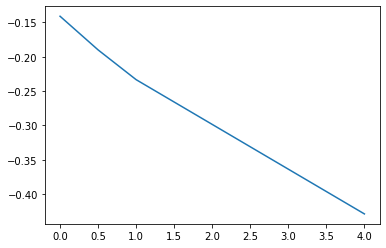

In [22]:
plot_model(make_model())

Num param: 22
Num data: 9


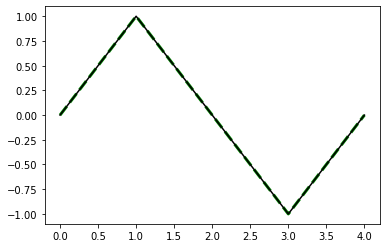

<function mse_loss at 0x7f11c2910510>


,epoch,batch_idx,mean|p|,mean|Δp|,loss,activation_ratios
0,pre-opt,n/a,0.681818,0.0,0.0,"1.00, 1.00"
1,0,0,0.681818,0.0,0.0,"1.00, 1.00"
2,1,0,0.681818,0.0,0.0,"1.00, 1.00"
3,2,0,0.681818,0.0,0.0,"1.00, 1.00"


In [23]:
# Sanity check against gt.
fit(gt_model())

Num param: 22
Num data: 9


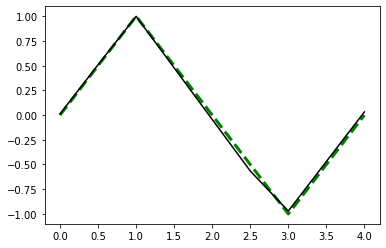

<function mse_loss at 0x7f11c2910510>


,epoch,batch_idx,mean|p|,mean|Δp|,loss,activation_ratios
0,pre-opt,n/a,0.685325,0.000000,0.008283,"1.00, 1.00"
1,0,0,0.685329,0.000130,0.008283,"1.00, 1.00"
2,1,0,0.685337,0.000257,0.007690,"1.00, 1.00"
3,2,0,0.685347,0.000376,0.006594,"1.00, 1.00"
4,3,0,0.685359,0.000484,0.005156,"1.00, 1.00"
5,4,0,0.685371,0.000575,0.003586,"1.00, 1.00"
6,5,0,0.685399,0.000646,0.002113,"1.00, 1.00"
7,6,0,0.685445,0.000693,0.000952,"1.00, 1.00"
8,7,0,0.685595,0.000713,0.000276,"1.00, 1.00"
9,8,0,0.685863,0.000719,0.000131,"1.00, 1.00"


In [24]:
# Perturb a bit.
fit(perturb(gt_model(), 0.01), lr=0.001, num_epochs=10)

Num param: 22
Num data: 9


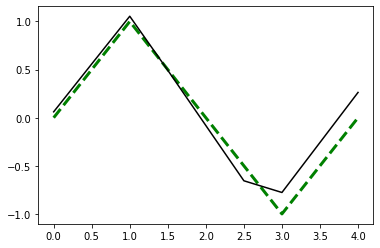

<function mse_loss at 0x7f11c2910510>


,epoch,batch_idx,mean|p|,mean|Δp|,loss,activation_ratios
0,pre-opt,n/a,0.699354,0.000000,0.198774,"1.00, 1.00"
1,0,0,0.699287,0.000630,0.198774,"1.00, 1.00"
2,1,0,0.699166,0.001184,0.188585,"1.00, 1.00"
3,2,0,0.699009,0.001605,0.172543,"1.00, 1.00"
4,3,0,0.698877,0.002039,0.153648,"1.00, 1.00"
5,4,0,0.698779,0.002396,0.119777,"1.00, 1.00"
6,5,0,0.698757,0.002689,0.080718,"1.00, 1.00"
7,6,0,0.698856,0.002937,0.043971,"1.00, 1.00"
8,7,0,0.699224,0.003144,0.017921,"1.00, 1.00"
9,8,0,0.700177,0.003291,0.007678,"1.00, 1.00"


In [25]:
fit(perturb(gt_model(), 0.05), lr=0.001, num_epochs=10)

Num param: 61
Num data: 9


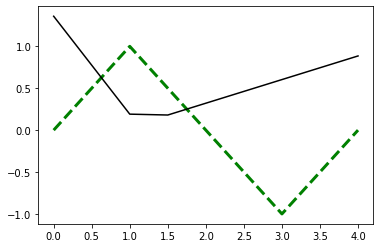

<function mse_loss at 0x7f11c2910510>


,epoch,batch_idx,mean|p|,mean|Δp|,loss,activation_ratios
0,pre-opt,n/a,0.796849,0.000000,3.263537,"0.33, 0.67"
1,0,0,0.791480,0.009450,3.263537,"0.33, 0.67"
2,1,0,0.784390,0.012164,1.470252,"0.33, 0.67"
3,2,0,0.778564,0.010846,1.650915,"0.33, 0.67"
4,3,0,0.772021,0.009953,2.252201,"0.33, 0.67"
5,4,0,0.764452,0.013402,1.807887,"0.33, 0.67"


In [26]:
# Yuck. Not robust.
fit(perturb(make_model(), 1.0), lr=0.01, num_epochs=5)